25


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:17:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.8240
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5860
           1       0.67      0.39      0.49      1640

    accuracy                           0.82      7500
   macro avg       0.76      0.67      0.69      7500
weighted avg       0.81      0.82      0.81      7500


Final Training Log Loss: 0.3043
Final Test Log Loss: 0.4250


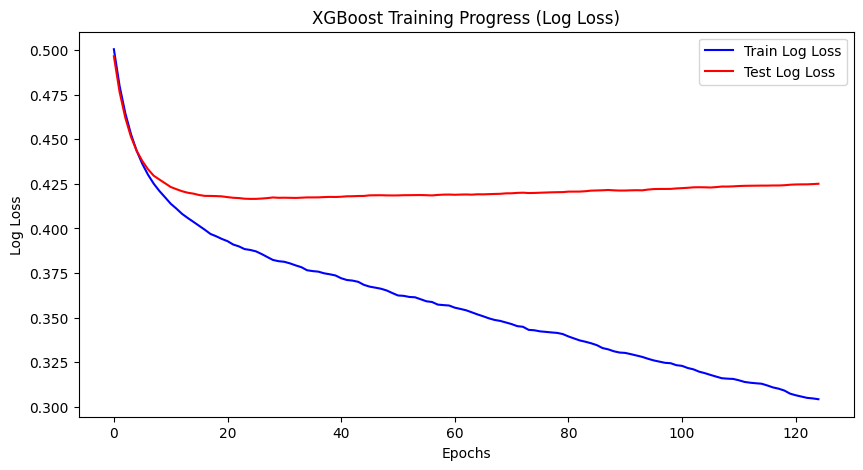

In [ ]:
#extra script, used for analyzing more about the improvements.
%run /home/jui/thesis-code/Thesis-code/RAI-implementation/Baseline-model.ipynb

In [ ]:
%run /home/jui/thesis-code/Thesis-code/RAI-implementation/Improved-model.ipynb

2.18.0
True
0    23364
1     6636
Name: default payment next month, dtype: int64
(30000, 25)


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


2    18112
1    18112
Name: SEX, dtype: int64
PR-AUC: 0.5775005059302372
Model Accuracy: 0.8419
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7305
           1       0.66      0.37      0.47      1751

    accuracy                           0.84      9056
   macro avg       0.76      0.66      0.69      9056
weighted avg       0.82      0.84      0.82      9056


Final Training Log Loss: 0.3026
Final Test Log Loss: 0.3941


(7500,)
(7500,)
(7500,)
Stayed Correct     5085
Wrong → Correct    1231
Stayed Wrong        828
Correct → Wrong     356
Name: category, dtype: int64


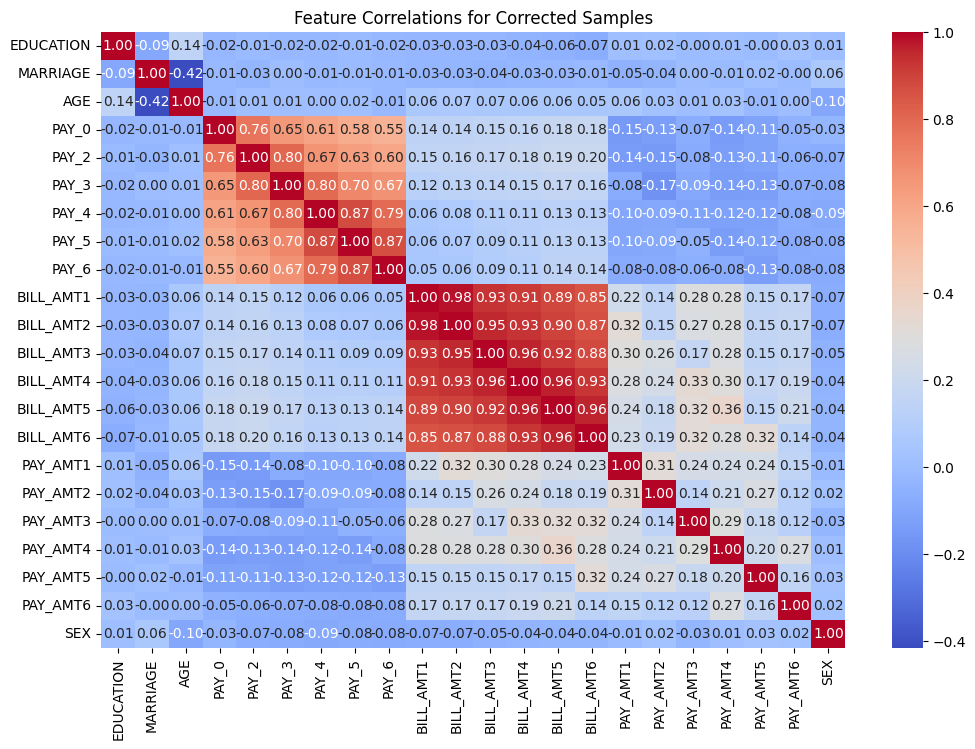

In [4]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# Trim y_test and y_pred_improved to match 7500 samples
y_test = y_test[:7500]
y_test = y_test.ravel()
y_pred_improved = y_pred_improved[:7500]

print(y_test.shape)
print(y_pred_baseline.shape)
print(y_pred_improved.shape)

# Create DataFrame for comparison
df_comparison = pd.DataFrame({
    'y_true': y_test,
    'y_pred_baseline': y_pred_baseline,
    'y_pred_improved': y_pred_improved
})

# Baseline correctness
df_comparison['baseline_correct'] = df_comparison['y_pred_baseline'] == df_comparison['y_true']

# Improved model correctness
df_comparison['improved_correct'] = df_comparison['y_pred_improved'] == df_comparison['y_true']

def compare_models(row):
    if row['baseline_correct'] and row['improved_correct']:
        return 'Stayed Correct'
    elif not row['baseline_correct'] and not row['improved_correct']:
        return 'Stayed Wrong'
    elif row['baseline_correct'] and not row['improved_correct']:
        return 'Correct → Wrong'
    elif not row['baseline_correct'] and row['improved_correct']:
        return 'Wrong → Correct'


# Reset index of X_test and preserve original indices
X_test = X_test.reset_index(drop=True)

# Apply comparison function
df_comparison['category'] = df_comparison.apply(compare_models, axis=1)

# Samples that stayed correct
stayed_correct = df_comparison[df_comparison['category'] == 'Stayed Correct']

# Samples that stayed wrong
stayed_wrong = df_comparison[df_comparison['category'] == 'Stayed Wrong']

# Samples that went from correct → wrong
correct_to_wrong = df_comparison[df_comparison['category'] == 'Correct → Wrong']

# Samples that went from wrong → correct (IMPROVEMENT)
wrong_to_correct = df_comparison[df_comparison['category'] == 'Wrong → Correct']

summary = df_comparison['category'].value_counts()
print(summary)

# Correlation matrix of corrected samples
corrected_corr = X_test.iloc[wrong_to_correct.index].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corrected_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlations for Corrected Samples')
plt.show()


In [14]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Assuming you have:
# - baseline_model: Your baseline trained model
# - improved_model: Your improved trained model
# - X_test: Test features
# - y_test: Test labels
# - df_comparison: DataFrame with 'category' column (Stayed Correct, Stayed Wrong, Correct → Wrong, Wrong → Correct)

# Explain baseline model
explainer_baseline = shap.TreeExplainer(pipeline)  # Replace with your baseline model
shap_values_baseline = explainer_baseline.shap_values(X_test_og)

# Explain improved model
explainer_improved = shap.TreeExplainer(model_improved)  # Replace with your improved model
shap_values_improved = explainer_improved.shap_values(X_test)

# Create DataFrames to store SHAP values
shap_df_baseline = pd.DataFrame(shap_values_baseline, columns=X_test_og.columns)
shap_df_improved = pd.DataFrame(shap_values_improved, columns=X_test.columns)

# Add the category column to both SHAP DataFrames
shap_df_baseline['category'] = df_comparison['category']
shap_df_improved['category'] = df_comparison['category']

# Analyze SHAP values for each category
for category in df_comparison['category'].unique():
    print(f"\nAnalyzing category: {category}")
    
    # Subset SHAP values for the current category
    category_shap_baseline = shap_df_baseline[shap_df_baseline['category'] == category].drop(columns='category')
    category_shap_improved = shap_df_improved[shap_df_improved['category'] == category].drop(columns='category')
    
    # Calculate mean absolute SHAP values for each feature (baseline)
    mean_shap_baseline = category_shap_baseline.abs().mean().sort_values(ascending=False)
    
    # Calculate mean absolute SHAP values for each feature (improved)
    mean_shap_improved = category_shap_improved.abs().mean().sort_values(ascending=False)
    
    # Get top 4 features for the baseline model
    top_features_baseline = mean_shap_baseline.head(4)
    print(f"\nTop 4 features for baseline model in category '{category}':")
    print(top_features_baseline)
    
    # Get top 4 features for the improved model
    top_features_improved = mean_shap_improved.head(4)
    print(f"\nTop 4 features for improved model in category '{category}':")
    print(top_features_improved)
    
    # Compare the top features
    common_features = set(top_features_baseline.index).intersection(set(top_features_improved.index))
    print(f"\nCommon top features between baseline and improved models for category '{category}':")
    print(common_features)
    
    # Visualize SHAP summary plots for both models
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values_baseline, X_test_og, plot_type='bar', max_display=4, show=False)
    plt.title(f'Baseline Model: {category}')
    
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values_improved, X_test, plot_type='bar', max_display=4, show=False)
    plt.title(f'Improved Model: {category}')
    
    plt.tight_layout()
    plt.show()

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>